In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [3]:
prices = pd.read_csv('../input/dogecoinprices/full_data__4__2021.csv/full_data__4__2021.csv')
sentiment = pd.read_csv('../input/dogecoinprices/doge-tweets-sentiment-prices.csv')

sentiment.head()

,date,vader_negative,vader_neutral,vader_positive,tweet_length,vader_scale,tweets_vol,Close
0,2021-04-16 06:01:00,0.017187,0.911794,0.071019,13.700935,3.495327,107,0.255806
1,2021-04-16 06:02:00,0.036131,0.897935,0.065935,14.214953,3.420561,107,0.256923
2,2021-04-16 06:03:00,0.031773,0.902023,0.066216,14.261364,3.431818,88,0.255143
3,2021-04-16 06:04:00,0.026615,0.912115,0.061271,15.020833,3.479167,96,0.256478
4,2021-04-16 06:05:00,0.009549,0.878044,0.112385,12.109890,3.340659,91,0.258904


In [4]:
sentiment.shape

(6477, 8)

In [5]:
sentiment.isna().sum()

date              0
vader_negative    0
vader_neutral     0
vader_positive    0
tweet_length      0
vader_scale       0
tweets_vol        0
Close             0
dtype: int64

In [6]:
sentiment.set_index('date', inplace=True)

In [7]:
prices = sentiment[['Close']]
prices.tail()

,Close
date,
2021-04-20 17:53:00,0.349367
2021-04-20 17:54:00,0.349804
2021-04-20 17:55:00,0.352680
2021-04-20 17:56:00,0.350923
2021-04-20 17:57:00,0.353917


## Data Preprocessing

### 1. Sentiment Preprocessing

In [8]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

X = sentiment.iloc[:, :-1]
y = sentiment[['Close']]

train_split = 0.9
data_len = int(y.shape[0] * train_split)

features_scaler = MinMaxScaler(feature_range=(-1, 1))
target_scaler = MinMaxScaler()

X = features_scaler.fit_transform(X)
y = target_scaler.fit_transform(y)

X_train = X[:data_len]
y_train = y[:data_len]
X_test = X[data_len:]
y_test = y[data_len:]

### Add TimeStamp

As we working with multi input model, we can not fit our model with generators, so we have to do it manually.

In [9]:
# split a multivariate sequence into samples
def Timeseries_sequences(sequences, target, length,):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + length
        # check if we are beyond the dataset
        if end_ix > len(sequences) - 1: 
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], target[end_ix-1, :] 
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [10]:
sr = 2
lb = 60*sr # hours

X_train_sent, y_train_sent = Timeseries_sequences(X_train, y_train, length=lb)
X_test_sent, y_test_sent = Timeseries_sequences(X_test, y_test, length=lb)

In [11]:
X_train_sent.shape, y_train_sent.shape

((5709, 120, 6), (5709, 1))

### 2. Prices Preprocessing

In [12]:
X_train_price, y_train_price = Timeseries_sequences(y_train, y_train, length=lb)
X_test_price, y_test_price = Timeseries_sequences(y_test, y_test, length=lb)

## Model

In [13]:
import tensorflow as tf

from tensorflow.keras.models import Model
#from keras.layers.merge import concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

from tensorflow.keras.optimizers import SGD, Adam

In [14]:
sent_shape = X_train_sent.shape[1:]
price_shape = X_train_price.shape[1:]

sent_shape, price_shape

((120, 6), (120, 1))

In [15]:
# design a parallel model

sent_input = Input(shape=sent_shape, name='sentiment_input') # x1
price_input = Input(shape=price_shape, name='prices_input') # x2

# sentiment Network
x1 = LSTM(32, return_sequences=True, name='sentiment_LSTM_sequences')(sent_input)
x1 = LSTM(4, name='sentiment_LSTM')(x1)
x1 = Dense(4, name='sentiment_vector_representation')(x1)

# prices Network
x2 = LSTM(32, return_sequences=True, name='prices_LSTM_sequences')(price_input)
x2 = LSTM(4, name='prices_LSTM')(x2)
x2 = Dense(4, name='prices_vector_representation')(x2)

# concatenate both
out = Concatenate(axis=-1, name='merge')([x1, x2])

# fully-connected
out = Dense(1, name='output')(out)

model = Model(inputs=[sent_input, price_input], outputs=out)

# show model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentiment_input (InputLayer)    [(None, 120, 6)]     0                                            
__________________________________________________________________________________________________
prices_input (InputLayer)       [(None, 120, 1)]     0                                            
__________________________________________________________________________________________________
sentiment_LSTM_sequences (LSTM) (None, 120, 32)      4992        sentiment_input[0][0]            
__________________________________________________________________________________________________
prices_LSTM_sequences (LSTM)    (None, 120, 32)      4352        prices_input[0][0]               
______________________________________________________________________________________________

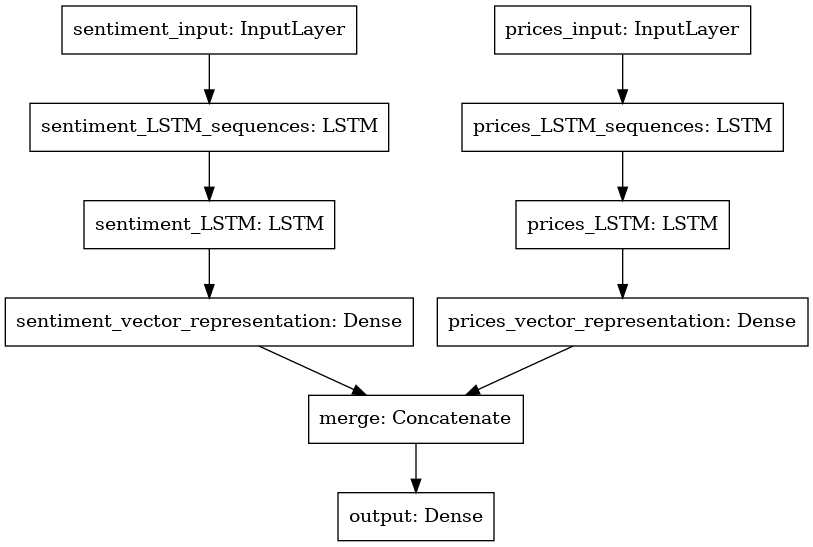

In [16]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    #show_layer_activations=False,
)

In [17]:
# model callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)
reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

# loss function
huber_loss = tf.keras.losses.Huber()
model.compile(loss=huber_loss, optimizer=Adam(learning_rate=0.1))

# Traning
history = model.fit([X_train_sent, X_train_price], y_train_price,
                    validation_data=([X_test_sent, X_test_price], y_test_price), 
                    batch_size=256,
                    shuffle=False,
                    callbacks=[es, reduce_lr],
                    epochs=1000,
                    verbose=1,
                   )

Epoch 1/1000
23/23 [==============================] - 9s 78ms/step - loss: 0.0291 - val_loss: 0.0042
Epoch 2/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.0122 - val_loss: 0.0042
Epoch 3/1000
23/23 [==============================] - 1s 23ms/step - loss: 0.0037 - val_loss: 0.0011
Epoch 4/1000
23/23 [==============================] - 1s 23ms/step - loss: 7.9886e-04 - val_loss: 7.8514e-04
Epoch 5/1000
23/23 [==============================] - 1s 23ms/step - loss: 9.2292e-04 - val_loss: 6.1425e-04
Epoch 6/1000
23/23 [==============================] - 1s 23ms/step - loss: 6.6959e-04 - val_loss: 4.6489e-04
Epoch 7/1000
23/23 [==============================] - 1s 29ms/step - loss: 6.4528e-04 - val_loss: 4.5385e-04
Epoch 8/1000
23/23 [==============================] - 1s 26ms/step - loss: 6.4820e-04 - val_loss: 4.2406e-04
Epoch 9/1000
23/23 [==============================] - 1s 24ms/step - loss: 5.8138e-04 - val_loss: 4.1560e-04
Epoch 10/1000
23/23 [======================

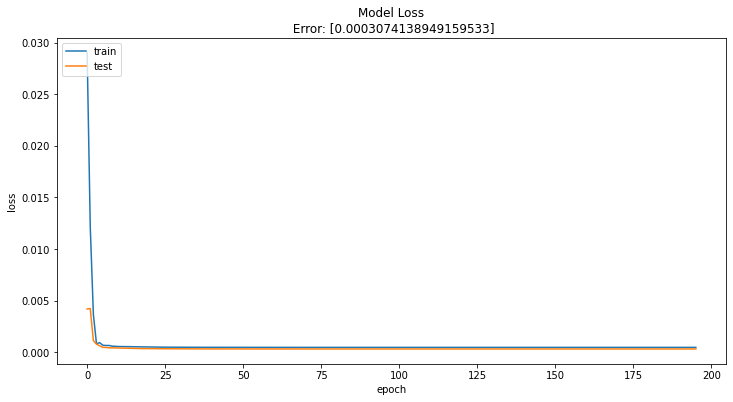

In [18]:
# summarize history for loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f"Model Loss\n Error: [{np.min(history.history['val_loss'])}]")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Predictions

In [19]:
# predict and compare
pred = target_scaler.inverse_transform(model.predict([X_test_sent, X_test_price]))
true = target_scaler.inverse_transform(y_test_price)

print('Real Mean-Aabsolute-Error:', np.mean(abs(pred-true)))

Real Mean-Aabsolute-Error: 0.004258592293352311


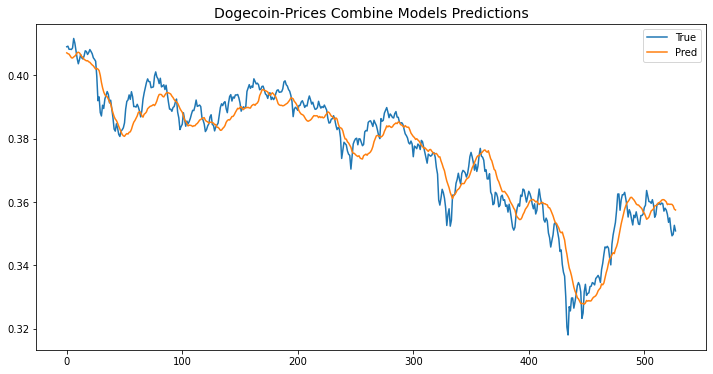

In [20]:
# plot the results
plt.figure(figsize=(12, 6))
plt.plot(true, label='True');
plt.plot(pred, label='Pred')
plt.title(f'Dogecoin-Prices Combine Models Predictions', fontsize=14)
plt.legend();

## Conclusion:

**The Real Mean-Aabsolute-Error is very good, also predictions fit very well, even better than each model alone.**